In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install -U imbalanced-learn
!pip install scipy

    100% |████████████████████████████████| 1.4MB 22.3MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/ee/80/75b684060dc6ecc5a28c07b75ef4063f378aff1a37556f342a
Successfully built python-decouple
     |████████████████████████████████| 1.5MB 4.4MB/s eta 0:00:01
     |████████████████████████████████| 174kB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 5.4MB 47.3MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [37]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow,
                                incident.hour
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.hour,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def process_data(data, start_year, end_year):

    NUM_BLOCKIDS = 801
    
    X = np.zeros((NUM_BLOCKIDS, 24, 7*24))
    y = np.zeros((NUM_BLOCKIDS, 12, 7*24))
    blockid_dict = {}

    # Create random array (BLOCKIDS) from 1-801 inclusive
    # of length NUM_BLOCKIDS
    BLOCKIDS = random.choices(list(range(1,802)), k=NUM_BLOCKIDS)
    
    for ind, blockid in enumerate(BLOCKIDS):
        blockid_dict[blockid] = ind

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, 24*r[3]+r[4]] = r[5]
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, 24*r[3]+r[4]] = r[5]
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week                
    
    return X, y

In [6]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year)
        X_test, y_test = process_data(testing_data,
                                        testing_start_year, 
                                        testing_end_year)

    return X_train, X_test, y_train, y_test

In [7]:
%%time
X_train, X_test, y_train, y_test = ready_data(2015, 2017, 2016, 2018)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


CPU times: user 3.09 s, sys: 298 ms, total: 3.39 s
Wall time: 1min 8s


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((801, 24, 168), (801, 12, 168), (801, 24, 168), (801, 12, 168))

In [9]:
X_train[:, 6, 118]

array([0.00000000e+00, 2.24014337e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05069609e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.47167035e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.81250000e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## Predictions

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Dropout
from keras.optimizers import Adam
import keras.backend as K

def perc_error(y_true, y_pred):
    return 100.0 * K.mean((y_true - y_pred) / y_true)

def predict(X_train, y_train, X_test, y_test):
    data_dim    = 7 * 24   # All values in each hour of the week
    timesteps   = 2 * 12   # Summed per month
    batch_size  = 64
    num_outputs = 7 * 24 * 12

    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(1024, return_sequences=True, 
                   input_shape=(timesteps, # 24
                                data_dim), # 168
                   activation='relu',
                   kernel_initializer='random_uniform',
                   bias_initializer='zeros'
                  )
             )
    model.add(LSTM(1024, return_sequences=True, input_shape=(timesteps, data_dim)))
    model.add(LSTM(128, input_shape=(timesteps, data_dim), activation='relu'))
    model.add(Dense(num_outputs, activation='relu'))
    model.add(Reshape((12, 7 * 24)))

    model.compile(loss='mean_squared_error',
                   optimizer=Adam(lr=0.1))

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=10,
                        validation_data=(X_test, y_test))

    mse = model.evaluate(X_test, y_test,
                         batch_size=batch_size)
    print('Test MSE:', mse)
    return history, model

In [11]:
history, model = predict(X_train, y_train, X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 801 samples, validate on 801 samples
Epoch 1/10
801/801 [==============================] - 11s 14ms/step - loss: 50317.2864 - val_loss: 0.0047
Epoch 2/10
801/801 [==============================] - 5s 6ms/step - loss: 21.2191 - val_loss: 4.0800e-08
Epoch 3/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-08 - val_loss: 4.0800e-08
Epoch 4/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-08 - val_loss: 4.0800e-08
Epoch 5/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-08 - val_loss: 4.0800e-08
Epoch 6/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-08 - val_loss: 4.0800e-08
Epoch 7/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-08 - val_loss: 4.0800e-08
Epoch 8/10
801/801 [==============================] - 5s 6ms/step - loss: 1.8991e-0

In [12]:
type(history.history['loss'])

list

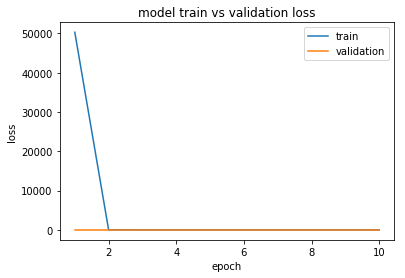

In [13]:
plt.plot(range(1,11), history.history['loss'])
plt.plot(range(1,11), history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

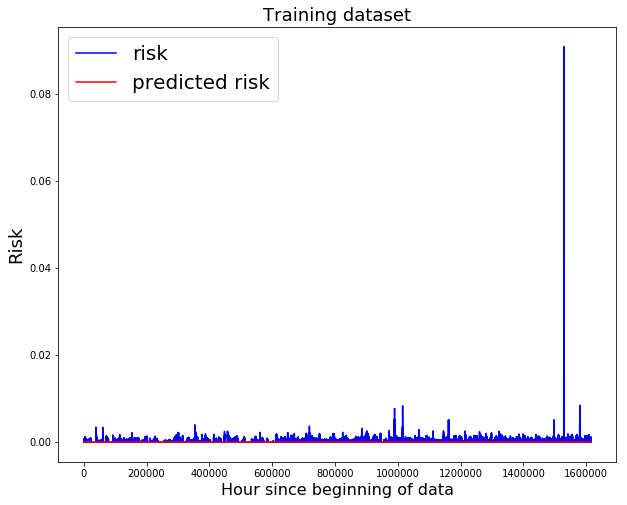

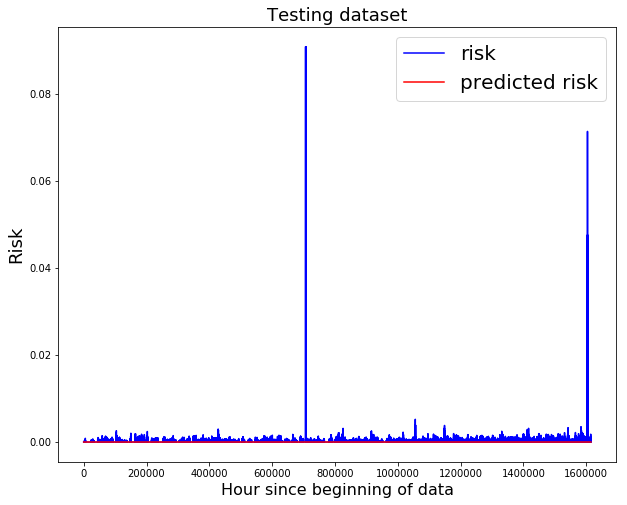

In [14]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

plot_output(y_train, y_train_pred, 'Training')
plot_output(y_test, y_test_pred, 'Testing')

In [15]:
def print_y_stats(s, y):
    num_spaces = 2
    if isinstance(y, pd.core.series.Series):
        y_flat = y
    elif isinstance(y, np.ndarray):
        y_flat = y.flatten()
    else:
        raise ValueError('Could not process type:', type(y))
        
    print(s)
    print(' ' * num_spaces, 'min: ', min(y_flat))
    print(' ' * num_spaces, 'max: ', max(y_flat))
    print(' ' * num_spaces, 'mean:', np.mean(y_flat))
    print(' ' * num_spaces, 'std: ', np.std(y_flat))
    return min(y_flat), max(y_flat), np.mean(y_flat), np.std(y_flat)

In [16]:
_, _, _, y_train_std = print_y_stats('y_train:', y_train)
print()
print_y_stats('y_test:', y_test)

y_train:
   min:  0.0
   max:  0.09090909090909091
   mean: 2.4448839331885725e-05
   std:  0.00013562345847518235

y_test:
   min:  0.0
   max:  0.09090909090909091
   mean: 2.3451608612098916e-05
   std:  0.00020062386953986305


(0.0, 0.09090909090909091, 2.3451608612098916e-05, 0.00020062386953986305)

## Remove outliers

### Let's try filtering values that are 20 standard deviations above the mean

Number of values filtered from y_train: 79
Number of values filtered from y_test: 13


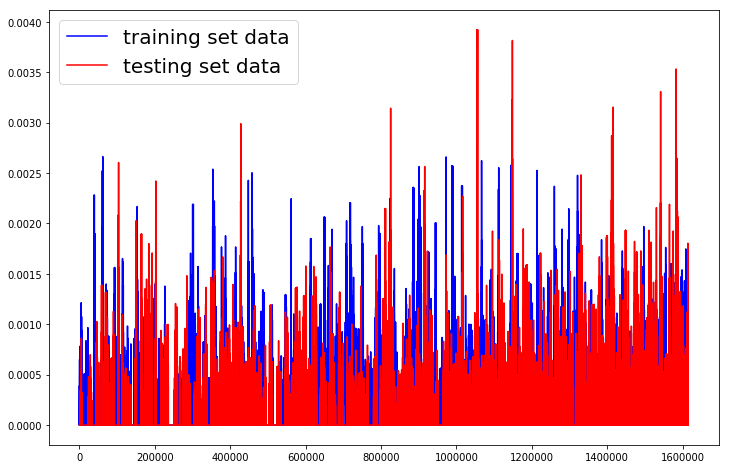

In [17]:
std = np.std(y_train)
y_train_filtered = y_train[y_train < 20*std] # Remove all values larger than 20 standard deviations

std = np.std(y_test)
y_test_filtered = y_test[y_test < 20*std]   # Remove all values larger than 20 standard deviations

print('Number of values filtered from y_train:', len(y_train[y_train > 20*std]))
print('Number of values filtered from y_test:', len(y_test[y_test > 20*std]))
fig = plt.figure(figsize=(12, 8))
plt.plot(y_train_filtered, color='blue');
plt.plot(y_test_filtered, color='red');
plt.legend(labels=['training set data', 'testing set data'], prop={'size': 20})
plt.show()

### With our threshold of 20 * std, we have removed 13 points from y_train and 12 from y_test. This is out of 1.6 million points, so they were defintely outliers. Let's run the prediction again with the updated y values

In [18]:
y_train_updated = np.where(y_train.flatten() < 20*std, y_train.flatten(), [0.]*len(y_train.flatten()))
y_test_updated  = np.where(y_test.flatten() < 20*std, y_test.flatten(), [0.]*len(y_test.flatten()))

predict(X_train, 
        y_train_updated.reshape((801, 12, 168)), 
        X_test, 
        y_test_updated.reshape((801, 12, 168)))

Train on 801 samples, validate on 801 samples
Epoch 1/10
801/801 [==============================] - 8s 10ms/step - loss: 1800339501.8225 - val_loss: 1162.9994
Epoch 2/10
801/801 [==============================] - 5s 6ms/step - loss: 13382.5136 - val_loss: 1.0264e-08
Epoch 3/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 4/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 5/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 6/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 7/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 8/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 - val_loss: 1.0264e-08
Epoch 9/10
801/801 [==============================] - 5s 6ms/step - loss: 1.1739e-08 

(<keras.callbacks.History at 0x7fa1a7e43be0>,
 <keras.engine.sequential.Sequential at 0x7fa1b0f09940>)

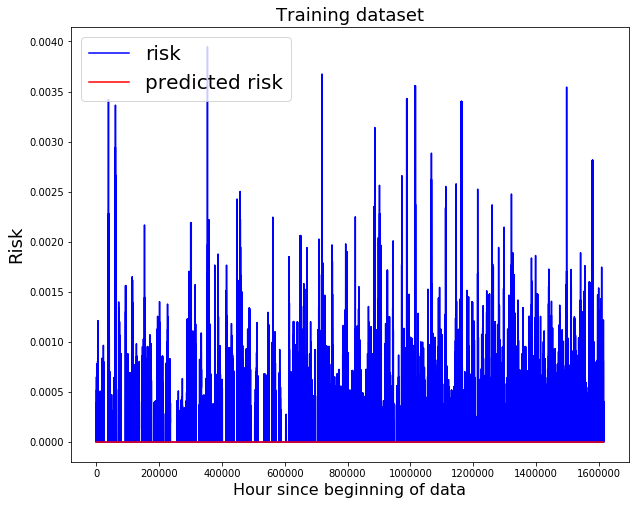

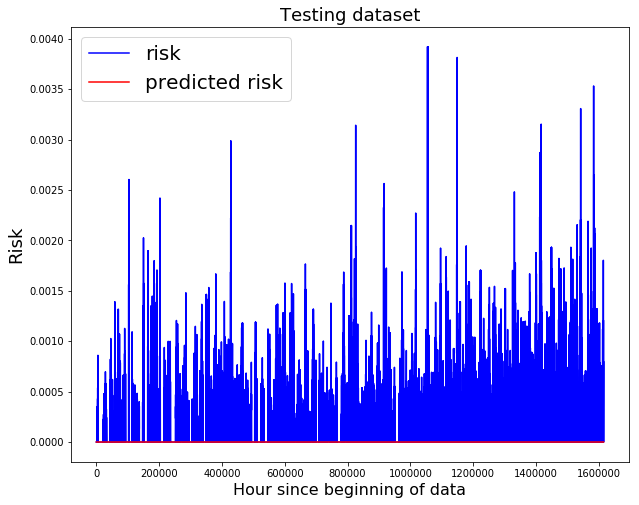

In [19]:
y_train_updated_pred = model.predict(X_train).flatten()
y_test_updated_pred = model.predict(X_test).flatten()

plot_output(y_train_updated, y_train_updated_pred, 'Training')
plot_output(y_test_updated, y_test_updated_pred, 'Testing')

### Distribution of y-values

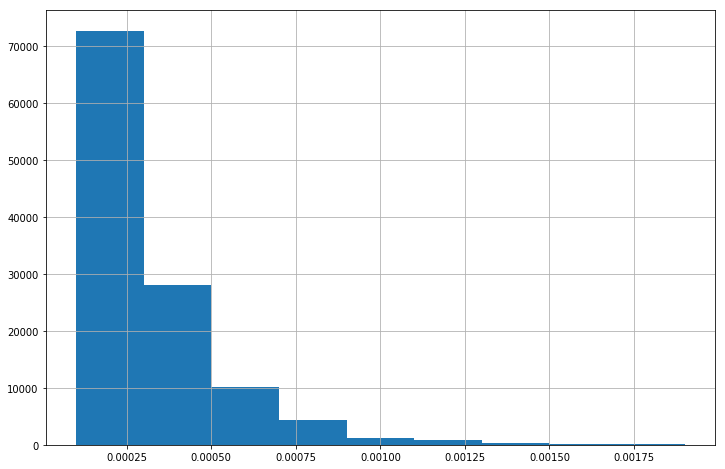

In [20]:
fig = plt.figure(figsize=(12,8))
pd.Series(y_train_updated).hist(bins=np.arange(0.0001, 0.002, 0.0002));

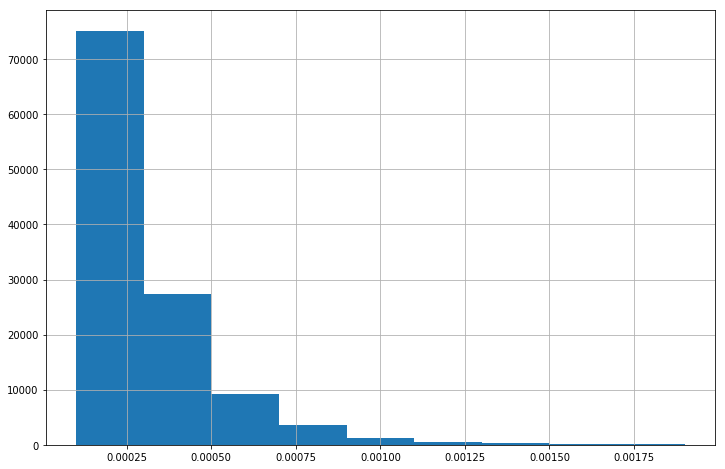

In [21]:
fig = plt.figure(figsize=(12,8))
pd.Series(y_test_updated).hist(bins=np.arange(0.0001, 0.002, 0.0002));

### This data seems reasonable, although it is a little lopsided. Still, it shouldn't cause the neural network to give us the large error that it is giving. Let's try giving the network the full set of features.

In [39]:
class GetDataFull(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
            SELECT incident.blockid, 
                    incident.year, 
                    incident.month, 
                    incident.dow, 
                    incident.hour,
                    SUM(crimetype.severity)/AVG(block.population) AS severity
            FROM incident
            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                AND block.population > 0
                AND severity > 0
                AND incident.cityid = 1
                AND incident.year >= {start_year}
                AND incident.year <= {end_year}
            GROUP BY
                incident.blockid,
                incident.year,
                incident.month,
                incident.dow,
                incident.hour
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [40]:
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

def day_of_week(dt):
    return dt.weekday()

def create_arrays(blockids, start_year, end_year):
    idx = 0
    X_blockid, X_year, X_month, X_dow, X_hour, X_risk = [], [], [], [], [], []
    for blockid in blockids:
        for year in range(start_year, end_year + 1):
            for month in range(1, 12 + 1):      # month range is 1-12
                for day in range(1, days_in_month(year, month) + 1):
                    for hour in range(24):      # hour range is 0-23
                        X_blockid.append(blockid)
                        X_year.append(year)
                        X_month.append(month)
                        X_dow.append(day_of_week(datetime(year, month, day)))
                        X_hour.append(hour)
                        X_risk.append(0.0)
                        idx += 1
    
    X = pd.DataFrame({'blockid':  X_blockid,
                      'year':     X_year,
                      'month':    X_month,
                      'dow':      X_dow,
                      'hour':     X_hour,
                      'risk':     X_risk})

    return X

In [44]:
def process_data_full(data, start_year, end_year):

    def remove_outliers_from_risk(risk):
        std = np.std(risk)
        risk = np.where(risk < 20*std, 
                     risk, 
                     [0.]*len(risk)).reshape(risk.shape)

        return risk
    
    NUM_BLOCKIDS = 801
    
    delta_years = end_year - start_year + 1
    
    blockid_dict = {}

    # Create random array (BLOCKIDS) from 1-801 inclusive
    # of length NUM_BLOCKIDS
    BLOCKIDS = random.choices(list(range(1,802)), k=NUM_BLOCKIDS)
    
    for ind, blockid in enumerate(BLOCKIDS):
        blockid_dict[blockid] = ind

    blockids = list(blockid_dict.values())
    X = create_arrays(blockids, start_year, end_year)

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    X1 = []
    for r in data:
        if r[0] in blockid_dict:            
            X1.append((r[0], r[1], r[2], r[3], r[4], r[5]))

    X1 = pd.DataFrame(data=X1,
                      columns=['blockid', 'year', 'month', 'dow', 'hour','risk2'])
    X = pd.merge(X, X1, 
                 how='left',
                 left_on=['blockid', 'year', 'month', 'dow', 'hour'],
                 right_on=['blockid', 'year', 'month', 'dow', 'hour']
                )
    X['all_risk'] = X.risk.astype(float) + X.risk2.astype(float)
    X = X.drop(columns=['risk', 'risk2']) \
         .rename(mapper={'all_risk': 'risk'}, axis=1)
    
    y = X['risk'].copy()
    X = X.drop(columns=['risk']).copy()
    y = remove_outliers_from_risk(y)
    
    return X, y

In [45]:
def ready_data_full(training_start_year, training_end_year,
                    testing_start_year, testing_end_year):
    with session_scope() as session:
        training_data = GetDataFull().go(session,
                                         training_start_year,
                                         training_end_year)
        testing_data = GetDataFull().go(session,
                                         testing_start_year,
                                         testing_end_year)
        X_train, y_train = process_data_full(training_data,
                                             training_start_year, 
                                             training_end_year)
        X_test, y_test = process_data_full(testing_data,
                                           testing_start_year, 
                                           testing_end_year)

    return X_train, X_test, y_train, y_test

In [46]:
%%time
X_train, X_test, y_train, y_test = ready_data_full(2015, 2016, 2017, 2018)

CPU times: user 49.4 s, sys: 7.03 s, total: 56.4 s
Wall time: 1min 44s


In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8789544, 5), (8789544,), (8917680, 5), (8917680,))

In [48]:
# def predict_full(X_train, y_train, X_test, y_test):
#     data_dim    = 5 # 7 * 24   # All values in each hour of the week
#     timesteps   = 2 * 12   # Summed per month
#     batch_size  = 64
#     num_outputs = 7 * 24 * 12

#     # expected input data shape: (batch_size, timesteps, data_dim)
#     model = Sequential()
#     model.add(LSTM(1024, return_sequences=True, 
# #                    input_shape=(timesteps, # 24
# #                                 data_dim), # 168
#                    activation='relu',
#                    kernel_initializer='random_uniform',
#                    bias_initializer='zeros'
#                   )
#              )
#     model.add(LSTM(1024, return_sequences=True, input_shape=(timesteps, data_dim)))
#     model.add(LSTM(128, input_shape=(timesteps, data_dim), activation='relu'))
#     model.add(Dense(num_outputs, activation='relu'))
#     model.add(Reshape((12, 7 * 24)))

#     model.compile(loss='mean_squared_error',
#                    optimizer=Adam(lr=0.1))

#     history = model.fit(X_train, y_train,
#                         batch_size=batch_size, epochs=10,
#                         validation_data=(X_test, y_test))

#     mse = model.evaluate(X_test, y_test,
#                          batch_size=batch_size)
#     print('Test MSE:', mse)
#     return history, model

In [49]:
# history, model = predict_full(X_train, y_train, X_test, y_test)